# Centered Kernel Alignment (CKA)

Ted Moskovitz, 2019

Perform centered kernel alignment (CKA) (Kornblith et al. 2019) to analyze network representations. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import itertools
import scipy.stats as spstats
from files import get_files

np.random.seed(324)

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['figure.figsize'] = (16.0, 8.0)
plt.rcParams['font.size'] = 22

**load the data**

In [3]:
data_dir = "/labs/common/share/"
#print (os.listdir(data_dir))
file_dict = get_files(ftype="activity")

In [5]:
# load the data 
activity_dict = {}
for net in file_dict.keys():
    for a in file_dict[net]:
        with open(data_dir + a, 'rb') as f:
            activity_dict[net] = pickle.load(f)
            
    print ("finished loading {}.".format(net))

finished loading supralinear.
finished loading linear.
finished loading local10_linear.
finished loading local40_supralinear.
finished loading local40_supralinear_variable_contrast.
finished loading local20_linear_nonnegative_inputs.
finished loading local10_linear_variable_contrast.
finished loading local25_supralinear_variable_contrast.
finished loading local20_linear_posInput_EOutput.
finished loading local20_supralinear_VC_posInput.
finished loading local20_linear_VC_posInput.
finished loading local20_supralinear_posInput.
finished loading local20_linear_posInput.
finished loading local20_supralinear_VC.
finished loading local20_linear_VC.
finished loading local20_supralinear_VC_posInput_EOutput.


In [6]:
print (activity_dict['local10_linear'].keys())

dict_keys(['conv4_state', 'conv5_state'])


In [7]:
# grab only only the last time step 
for model in activity_dict:
    for layer in activity_dict[model]:
        activity_dict[model][layer] = activity_dict[model][layer][-1]

In [8]:
# examine activity tensor shape: (N_examples, height, width, channels)
activity_dict['local10_linear']['conv4_state'].shape

(1024, 8, 8, 384)

**Perform CKA analysis on network representations. Details can be found in Kornblith et al. 2019, but the main idea is that most methods for comparing neural network representations (e.g., canonical correlations analysis) are either invariant to the wrong properties of different representations, or not invariant to those that they should be. The authors argue that a similarity metric for comparing representations should not be invariant to arbitrary invertible linear transformations, but should be invariant to orthogonal transformations and isotropic scaling. They use the Hilbert-Schmidt Independence Criterion (HSIC), which can generalize simple dot product-based similarity to kernelized similarity measures (although a linear kernel simply corresponds to dot product-based similarity). This measure is invariant with respect to orthogonal transformations, but not arbitary invertible linear transformations. To add independence to isotropic scaling, the HSIC is normalized:
$$
\text{CKA}(K,L) = \frac{\text{HSIC}(K,L)}{\sqrt{\text{HSIC}(K,K) \text{HSIC}(L,L)}},
$$
for kernel matrices $K$ and $L$.**

In [11]:
def HSIC(X, Y):
    """
    linear Hilbert-Schmidt Independence Criterion 
    TODO: add support for alternative kernels (e.g., RBF)
    params:
        - X, Y: network representations (must share first dimension)
    returns: 
        - similarity between representations 
    """
    n = X.shape[0]

    # compute similarities
    RSM_X = np.dot(X, X.T)
    RSM_Y = np.dot(Y, Y.T)
    
    criterion = np.trace(np.dot(RSM_X, RSM_Y)) / ((n - 1)**2)
    
    return criterion

def CKA(m1, m2, activity_dict, layer='conv4_state', n=256):
    """
    perform CKA 
    params:
         - m1, m2: models to compare (strings)
         - activity_dict: mapping of model to representation (dict)
         - layer: either 'conv4_state' or 'conv5_state' (strings)
         - n: number of examples to use (int)
    """
    # get activities
    X = activity_dict[m1][layer][:n, :, :, :]
    N, w, h, c = X.shape
    X = X.reshape(N, w*h*c)
    
    Y = activity_dict[m2][layer][:n, :, :, :]
    N, w, h, c = Y.shape
    Y = Y.reshape(N, w*h*c)
    
    # compute HSI criteria
    H_XY = HSIC(X, Y)
    H_XX = HSIC(X, X)
    H_YY = HSIC(Y, Y)

    return H_XY / np.sqrt(H_XX * H_YY)

In [12]:
# CKA matrices
models = list(activity_dict.keys())
N = len(models)
CKAs4 = np.zeros([N, N])
CKAs5 = np.zeros([N, N])
for i, m1 in enumerate(models):
    for j, m2 in enumerate(models):
        
        # compute CKAs
        cka4 = CKA(m1, m2, activity_dict, layer='conv4_state', n=256)
        cka5 = CKA(m1, m2, activity_dict, layer='conv5_state', n=256)
        
        CKAs4[i, j] = cka4
        CKAs5[i, j] = cka5
            

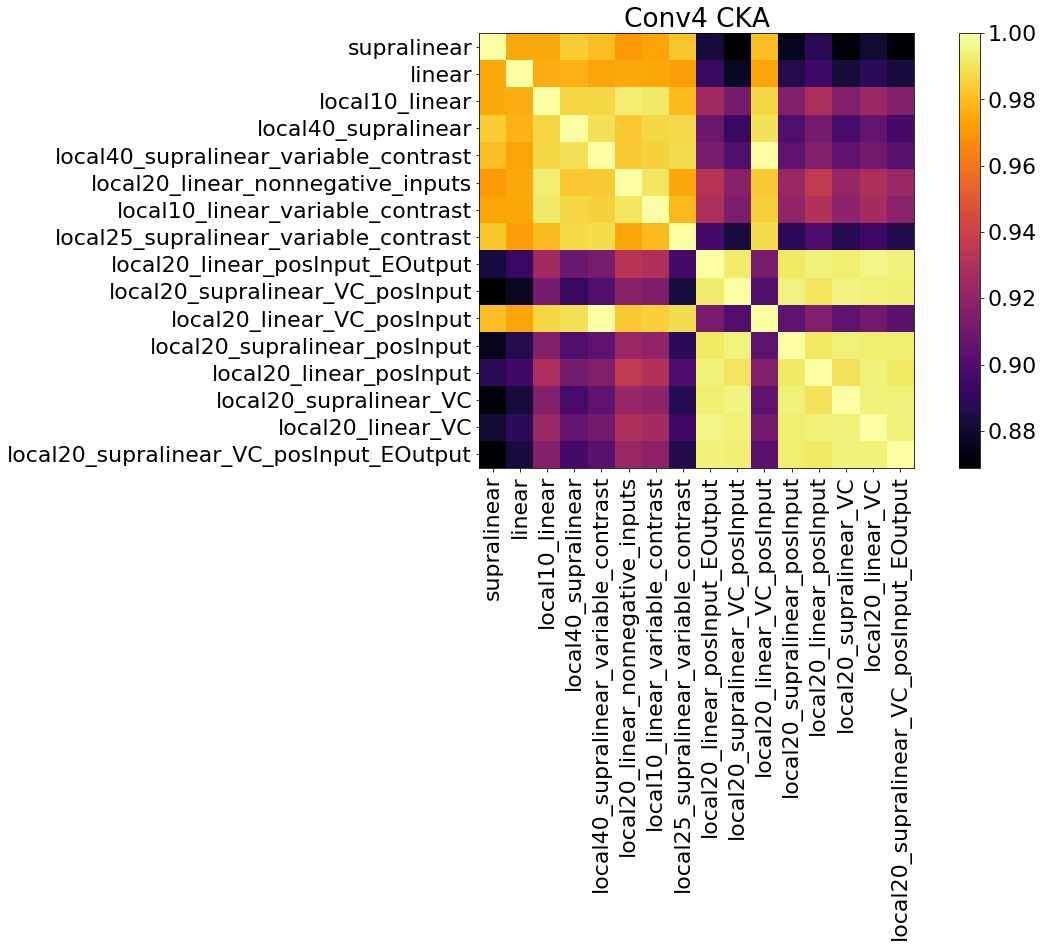

In [21]:
# conv4
idxs = np.arange(N)
plt.imshow(CKAs4)
plt.colorbar()
plt.xticks(idxs, models, rotation=90)
plt.yticks(idxs, models, rotation=0)
plt.title("Conv4 CKA")
plt.savefig('figs/CKA_conv4.pdf')
plt.show()

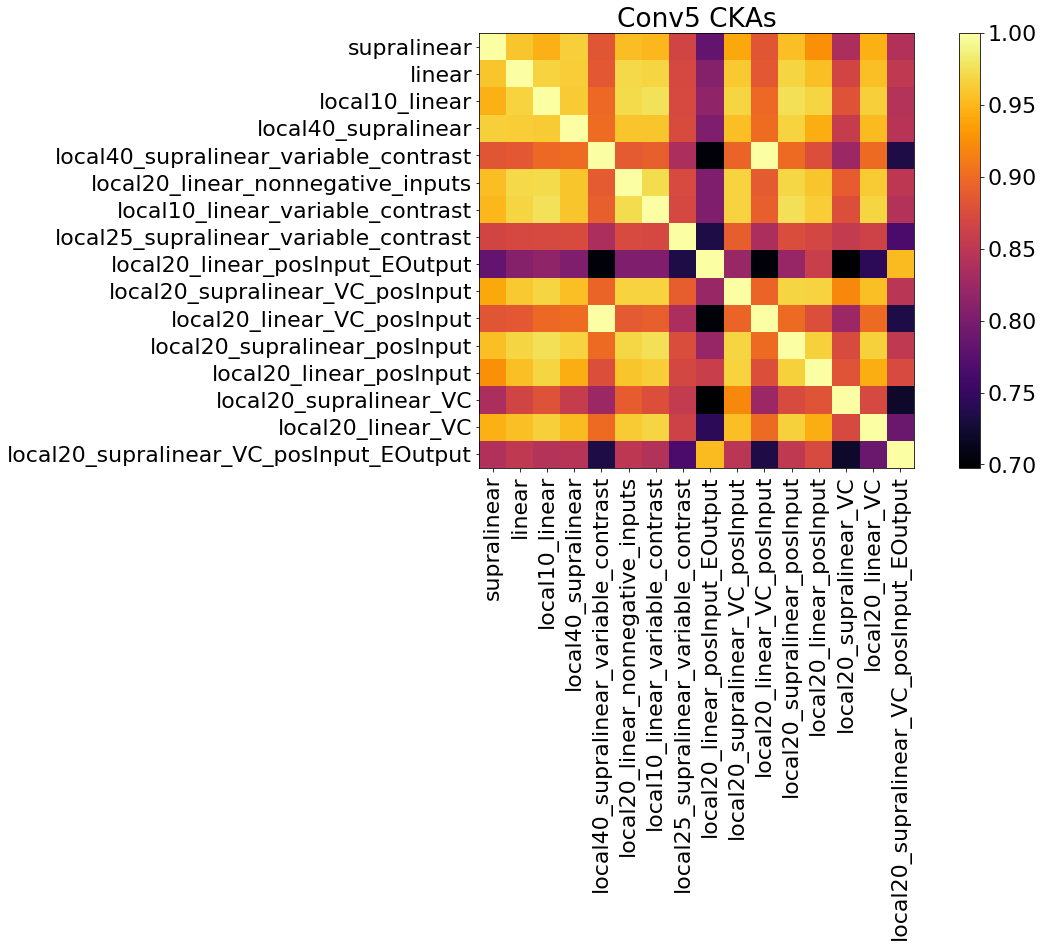

In [20]:
# conv5
idxs = np.arange(N)
plt.imshow(CKAs5)
plt.colorbar()
plt.xticks(idxs, models, rotation=90)
plt.yticks(idxs, models, rotation=0)
plt.title("Conv5 CKAs")
plt.savefig('figs/CKA_conv5.pdf')
plt.show()

**We can now cluster the models based on their computed similarities.**

In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


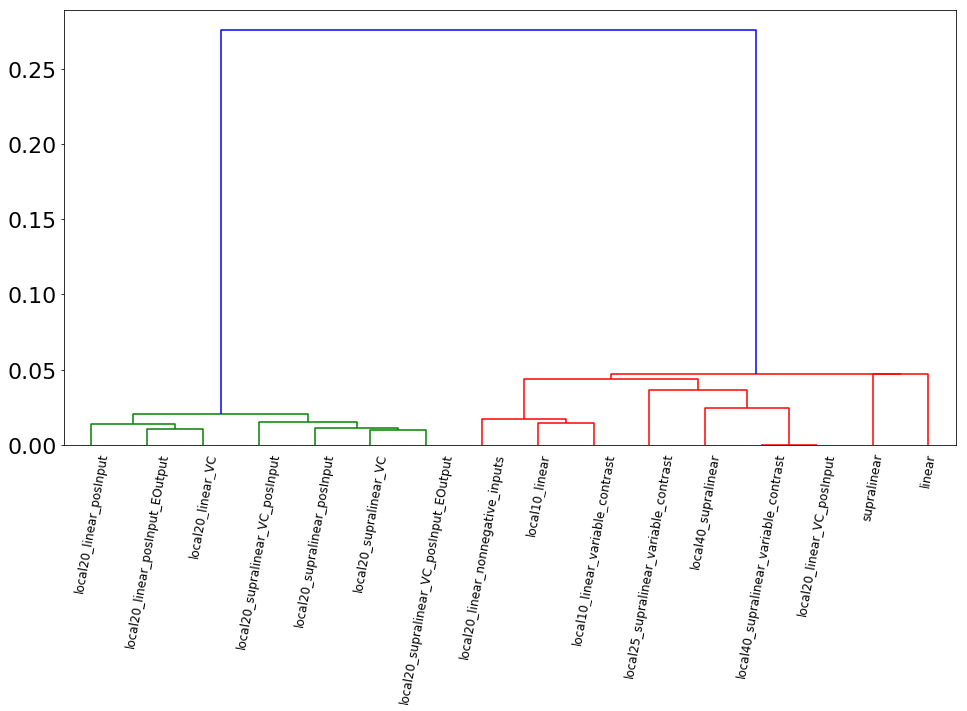

In [17]:
Z4 = linkage(1 - CKAs4, method='single')
fig = plt.figure(figsize=(16, 8))
dn4 = dendrogram(Z4, labels=models, leaf_rotation=80)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


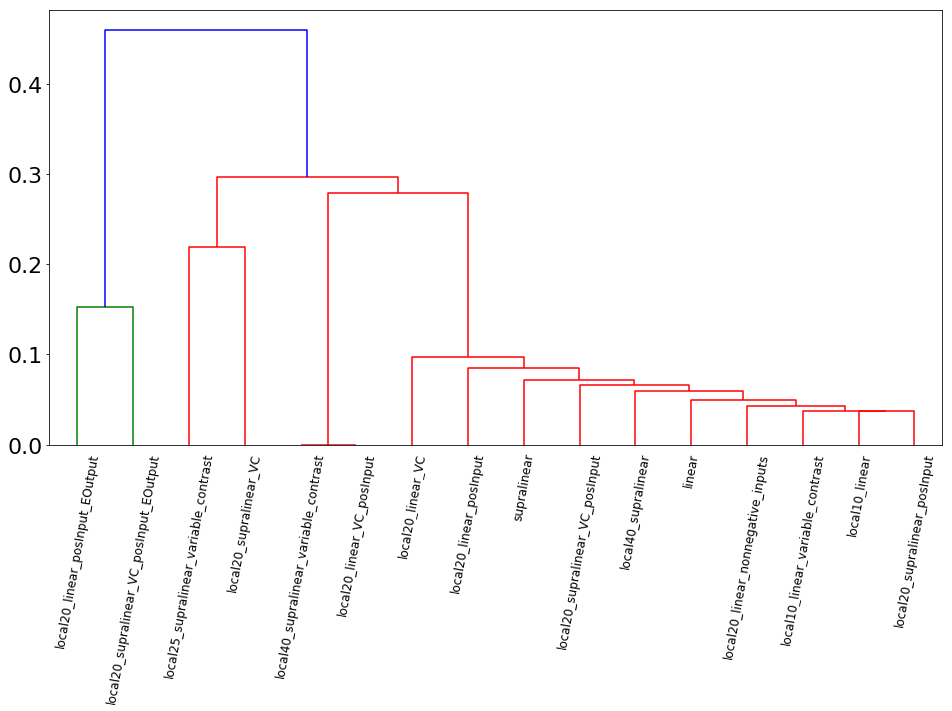

In [18]:
Z5 = linkage(1 - CKAs5, method='single')
fig = plt.figure(figsize=(16, 8))
dn5 = dendrogram(Z5, labels=models, leaf_rotation=80)
plt.show()